In [1]:
import math
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal as m_norm
import pickle
import seaborn as sns

from matplotlib import pyplot as plt
PATH = '../data/' # '/kaggle/input/nfl-big-data-bowl-2020/'
%matplotlib inline

In [2]:
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb

# Functions and classes

## Preprocessing

In [3]:
def preprocess(df, is_train=True):
    ## keep only important columns
    cols_to_drop = ['GameId', 'DisplayName', 'JerseyNumber', 'Quarter', 'GameWeather', 'Turf', 'Down', 'Distance', 
                    'GameClock', 'Dis', 'PlayerCollegeName', 'Stadium', 'Location', 'PlayerHeight', 'PlayerWeight',
                    'OffenseFormation', 'OffensePersonnel', 'DefensePersonnel', 'PlayerBirthDate', 'Position',
                    'TimeHandoff', 'TimeSnap', 'StadiumType', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection']
    df.drop(cols_to_drop, axis=1, inplace=True)
    
    if is_train:
        ## Adjust speed in 2017
        S_17_std = (df[df.Season == 2017].S - df[df.Season == 2017].S.mean())/df[df.Season == 2017].S.std()
        df.loc[df.Season == 2017, 'S'] = S_17_std * df[df.Season == 2018].S.std() + df[df.Season == 2018].S.mean()
    
        ## Adjust acceleration in 2018
        A_17_std = (df[df.Season == 2017].A - df[df.Season == 2017].A.mean())/df[df.Season == 2017].A.std()
        df.loc[df.Season == 2017, 'A'] = A_17_std * df[df.Season == 2018].A.std() + df[df.Season == 2018].A.mean()

    ## Fix abbreviations
    df.loc[df.HomeTeamAbbr == "ARI", 'HomeTeamAbbr'] = "ARZ"
    df.loc[df.HomeTeamAbbr == "BAL", 'HomeTeamAbbr'] = "BLT"
    df.loc[df.HomeTeamAbbr == "CLE", 'HomeTeamAbbr'] = "CLV"
    df.loc[df.HomeTeamAbbr == "HOU", 'HomeTeamAbbr'] = "HST"
    
    df.loc[df.VisitorTeamAbbr == "ARI", 'VisitorTeamAbbr'] = "ARZ"
    df.loc[df.VisitorTeamAbbr == "BAL", 'VisitorTeamAbbr'] = "BLT"
    df.loc[df.VisitorTeamAbbr == "CLE", 'VisitorTeamAbbr'] = "CLV"
    df.loc[df.VisitorTeamAbbr == "HOU", 'VisitorTeamAbbr'] = "HST"
    
    # Is player on offense or not?
    df['ToLeft'] = df.PlayDirection == "left"
    df['IsBallCarrier'] = df.NflId == df.NflIdRusher
    df['TeamOnOffense'] = "home"
    df.loc[df.PossessionTeam != df.HomeTeamAbbr, 'TeamOnOffense'] = "away"
    df['IsOnOffense'] = df.Team == df.TeamOnOffense

    ## fix YardLine 
    df['YardLine_std'] = 100 - df.YardLine
    cond = df.FieldPosition.fillna('') == df.PossessionTeam
    df.loc[cond, 'YardLine_std'] = df.loc[cond, 'YardLine']

    ## fix X, Y
    df['X_std'] = df.X
    df.loc[df.ToLeft, 'X_std'] = 120 - df.loc[df.ToLeft, 'X'] 
    df['Y_std'] = df.Y
    df.loc[df.ToLeft, 'Y_std'] = 160/3 - df.loc[df.ToLeft, 'Y'] 

    ## fix Dir
    df['Dir_rad'] = np.mod(90 - df.Dir, 360) * math.pi/180.0 
    df['Dir_std'] = df.Dir_rad
    df.loc[df.ToLeft, 'Dir_std'] = np.mod(np.pi + df.loc[df.ToLeft, 'Dir_rad'], 2*np.pi)

    ## fix Orientation
    df['Orientation_rad'] = np.mod(df.Orientation, 360) * math.pi/180.0
    df.loc[df.Season >= 2018, 
           'Orientation_rad'] = np.mod(df.loc[df.Season >= 2018, 'Orientation'] - 90, 360) * math.pi/180.0
    df['Orientation_std'] = df.Orientation_rad
    df.loc[df.ToLeft, 'Orientation_std'] = np.mod(np.pi + df.loc[df.ToLeft, 'Orientation_rad'], 2*np.pi)

    ## drop unnesessary columns
    cols_to_drop = ['PlayDirection', 'NflId', 'NflIdRusher', 'FieldPosition', 
                    'Team', 'PossessionTeam', 'HomeTeamAbbr', 'VisitorTeamAbbr', 'TeamOnOffense', 'ToLeft', 
                    'YardLine', 'X', 'Y', 'Dir', 'Dir_rad', 'Orientation', 'Orientation_rad']
    df.drop(cols_to_drop, axis=1, inplace=True)
    
    ## fill NaNs
    for col in ['DefendersInTheBox', 'Dir_std', 'Orientation_std']:
        df[col].fillna(df[col].median(), inplace=True)
    return df

## FE

### Pitch control features

In [4]:
def get_influence_radius(dist, min_rad=4, max_rad=10, dist_threshold=20):
    if dist <= dist_threshold:
        return min_rad + (max_rad - min_rad) * (dist/dist_threshold)**2
    else:
        return max_rad

In [5]:
def get_player_influence(row, row_rusher, delta_t=1, S_max=10, eps=1e-6):
    ## calc distribution mean
    mean = [row.X_std + delta_t * row.S * np.cos(row.Dir_std)/2, 
            row.Y_std + delta_t * row.S * np.sin(row.Dir_std)/2]
    
    ## calc distribution covariance matrix
    dist_to_rusher = np.sqrt((row.X_std - row_rusher.X_std)**2 + (row.Y_std - row_rusher.Y_std)**2)
    inf_radius = get_influence_radius(dist_to_rusher)
    R = np.array([[np.cos(row.Dir_std), -np.sin(row.Dir_std)], 
                  [np.sin(row.Dir_std), np.cos(row.Dir_std)]])
    S = np.array([[inf_radius * (1 + (row.S/S_max)**2)/2, 0], 
                  [0, inf_radius * (1 - (row.S/S_max)**2)/2]])
    cov = np.dot(np.dot(R, S), np.dot(S, np.linalg.inv(R)))
    
    ## calc and return normed pdf
    denom = m_norm.pdf([row.X_std, row.Y_std], mean=mean, cov=cov)
    influence = lambda x: m_norm.pdf(x, mean=mean, cov=cov)/(denom + eps)
    return influence 

In [6]:
def get_pitch_control(df_play, delta_t=1):
    row_rusher = df_play[df_play.IsBallCarrier].iloc[0]
    
    ## get offense and defense player influences
    get_inf = lambda row: get_player_influence(row, row_rusher, delta_t=delta_t)
    cond = (df_play.IsOnOffense) & (df_play.IsBallCarrier == False)
    offense_infs = df_play[cond].apply(get_inf, axis=1).values
    defense_infs = df_play[df_play.IsOnOffense == False].apply(get_inf, axis=1).values 
    
    ## get offense and defense pc
    offense_pc = lambda x: sum([inf(x) for inf in offense_infs]) 
    defense_pc = lambda x: sum([inf(x) for inf in defense_infs])
    return (offense_pc, defense_pc)

In [7]:
def get_ifo_rusher_pc(row_rusher, offset=0.5, r=0.5):
    X, Y, S, Dir = row_rusher.X_std, row_rusher.Y_std, row_rusher.S, row_rusher.Dir_std
    pc = row_rusher.pitch_control
    sign = 1 if np.sin(Dir) >= 0 else -1
    center = (X + offset * S * np.cos(Dir), Y + offset * S * np.sin(Dir))
    center_2 = (center[0] + r * S, center[1] + r * S)
    def_side = (center[0] + r * S, center[1])
    def_side_2 = (center[0] + 2 * r * S, center[1])
    off_side = (center[0], center[1] + sign * r * S)
    off_side_2 = (center[0], center[1] + 2 * sign * r * S)
    return (pc[0](center), pc[1](center), pc[1](center_2), 
            pc[1](def_side), pc[1](def_side_2), 
            pc[1](off_side), pc[1](off_side_2))

### Main function

In [8]:
def prepare_features(df, df_play):
    ## Speed features
    df_play['rusher_speed_x'] = df_play.S * np.cos(df_play.Dir_std)
    
    ## Distance features
    df_play['scrimmage_dist'] = df_play.X_std - df_play.YardLine_std
    
    ## Pitch control features
    g = df.groupby('PlayId').apply(get_pitch_control)
    df_play['pitch_control'] = df_play.PlayId.map(g)
    ifo_rusher_pc = df_play.apply(get_ifo_rusher_pc, axis=1)
    df_play['ifo_rusher_pc_offense_center'] = ifo_rusher_pc.apply(lambda x:x[0])
    df_play['ifo_rusher_pc_defense_center'] = ifo_rusher_pc.apply(lambda x:x[1])
    df_play['ifo_rusher_pc_defense_center_2'] = ifo_rusher_pc.apply(lambda x:x[2])
    df_play['ifo_rusher_pc_defense_defside'] = ifo_rusher_pc.apply(lambda x:x[3])
    df_play['ifo_rusher_pc_defense_defside_2'] = ifo_rusher_pc.apply(lambda x:x[4])
    df_play['ifo_rusher_pc_defense_offside'] = ifo_rusher_pc.apply(lambda x:x[5])
    df_play['ifo_rusher_pc_defense_offside_2'] = ifo_rusher_pc.apply(lambda x:x[5])
    
    return df, df_play

### Augmentation

In [16]:
def augmentate(array, is_target):
    result = []
    if is_target:
        for x in array:
            x_prev = x - 1
            x_next = x + 1
            for x_ in [x_prev, x, x_next]:
                result.append(x_)
    else:
        for row in array:
            row_prev = row.copy()
            row_next = row.copy()
            for r in [row_prev, row, row_next]:
                result.append(r)
    
    return np.array(result)

## Modelling and evaluation

In [10]:
class MultiLGBMClassifier():
    def __init__(self, model, resolution):
        ## smoothing size
        self.resolution = resolution
        ## initiarize models
        params = model.get_params()
        self.models = [lgb.LGBMClassifier(**params) for m in range(resolution)]
        
    def fit(self, x, y):
        self.classes_list = []
        for k in range(self.resolution):
            ## train each model
            self.models[k].fit(x, (y + k) // self.resolution)
            
            ## (0,1,2,3,4,5,6,7,8,9) -> (0,0,0,0,0,1,1,1,1,1) -> (0,5)
            classes = np.sort(list(set((y + k) // self.resolution))) * self.resolution - k
            classes = np.append(classes, 999)
            self.classes_list.append(classes)
            
    def plot_importances(self, column_names, importances=[], h_size=15, v_size=20):
        FI = pd.DataFrame()
        FI["names"] = column_names
        if len(importances) == 0:
            FI["importances"] = self.models[0].feature_importances_
        else:
            FI["importances"] = importances
        plt.figure(figsize=(h_size, v_size))
        sns.barplot(data=FI.sort_values(by="importances", ascending=False), 
                    x="importances", y="names")
        plt.title("Feature importances")
    
    def predict_proba(self, x):
        pred199_list = []
        for k in range(self.resolution):
            preds = self.models[k].predict_proba(x)
            classes = self.classes_list[k]
            pred199s = self.get_pred199(preds, classes)
            pred199_list.append(pred199s)
        self.pred199_list = pred199_list
        pred199_ens = np.mean(np.stack(pred199_list), axis = 0)
        return pred199_ens
    
    def _get_pred199(self, p, classes):
        ## categorical prediction -> predicted distribution whose length is 199
        pred199 = np.zeros(199)
        for k in range(len(p)):
            pred199[classes[k] + 99 : classes[k+1] + 99] = p[k]
        return pred199

    def get_pred199(self, preds, classes):
        pred199s = []
        for p in preds:
            pred199 = np.cumsum(self._get_pred199(p, classes))
            pred199 = pred199/np.max(pred199)
            pred199s.append(pred199)
        return np.vstack(pred199s)

In [11]:
def srps_score(y_true, y_pred, predict_type='pdf'):
    score = 0
    if predict_type == 'pdf':
        y_pred_cumsum = np.cumsum(y_pred, axis=1)
    else:
        y_pred_cumsum = np.array(y_pred)
    for n in range(199):
         score += ((y_pred_cumsum[:, n] - np.where(n - 99 >= y_true, 1, 0))**2).sum()
    return score/(199 * len(y_true))

In [21]:
def evaluate_model(model, df, features, print_process=True, 
                   cv_type='last_year', predict_type='pdf', n_splits=5):
    scores = []
    if cv_type == 'last_year':
        X_train = df.loc[df.Season == 2017, features].values
        y_train = df.loc[df.Season == 2017, 'Yards'].values
        model.fit(X_train, y_train)
        for week in range(df.Week.min(), df.Week.max() + 1):
            X_valid = df.loc[(df.Season == 2018) & (df.Week == week), 
                             features].values
            y_valid = df.loc[(df.Season == 2018) & (df.Week == week), 
                             'Yards'].values
            y_pred = model.predict_proba(X_valid)
            score = srps_score(y_valid, y_pred, 
                               predict_type=predict_type)
            if print_process:
                print("SRPS =", score, " on week", week)
            scores.append(score)
    elif cv_type == 'tss':
        X_17 = df.loc[df.Season == 2017, features].values
        y_17 = df.loc[df.Season == 2017, 'Yards'].values
        X_18 = df.loc[df.Season == 2018, features].values
        y_18 = df.loc[df.Season == 2018, 'Yards'].values
        cv = TimeSeriesSplit(n_splits=n_splits)
        cnt = 1
        for tr_index, val_index in cv.split(X_18):
            X_train = augmentate(np.vstack((X_17, X_18[tr_index])), 
                                 is_target=False)
            y_train = augmentate(np.hstack((y_17, y_18[tr_index])), 
                                 is_target=True)
            model.fit(X_train, y_train)
            y_pred = model.predict_proba(X_18[val_index])
            score = srps_score(y_18[val_index], y_pred, 
                               predict_type=predict_type)
            if print_process:
                print("SRPS =", score, " on fold", cnt)
            scores.append(score)
            cnt += 1
            
    scores = np.array(scores)
    if print_process:
        print("Mean SRPS:", scores.mean())
        print("Std of SRPS:", scores.std())
    return scores

In [13]:
def plot_custom_importances(model, df, features, scores=[], v_size=5, cv_type='last_year', predict_type='pdf'):
    ## Calc score with every feature
    if len(scores) == 0:
        scores_with = evaluate_model(model, df, features, print_process=False, 
                                     cv_type=cv_type, predict_type=predict_type)
    else:
        scores_with = np.array(scores)
        
    # Calc score without fixed feature
    importances = []
    for col in features:
        print('Checking', col, '...')
        other_features = list(features)
        other_features.remove(col)
        scores_without = evaluate_model(model, df, other_features, print_process=False, 
                                        cv_type=cv_type, predict_type=predict_type)
        scores_diff = scores_without - scores_with
        importances.append(scores_diff.mean())
        
    # plot importances
    model.plot_importances(features, importances=importances, v_size=v_size)

# Preprocessing and FE

In [14]:
%%time
df = pd.read_csv(PATH + 'train.csv', low_memory=False)
df = preprocess(df)
df_play = df[df.IsBallCarrier].drop(['IsOnOffense', 'IsBallCarrier'], axis=1)
df_play.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23171 entries, 18 to 509761
Data columns (total 14 columns):
PlayId                    23171 non-null int64
S                         23171 non-null float64
A                         23171 non-null float64
Season                    23171 non-null int64
HomeScoreBeforePlay       23171 non-null int64
VisitorScoreBeforePlay    23171 non-null int64
DefendersInTheBox         23171 non-null float64
Yards                     23171 non-null int64
Week                      23171 non-null int64
YardLine_std              23171 non-null int64
X_std                     23171 non-null float64
Y_std                     23171 non-null float64
Dir_std                   23171 non-null float64
Orientation_std           23171 non-null float64
dtypes: float64(7), int64(7)
memory usage: 2.7 MB
CPU times: user 3.67 s, sys: 438 ms, total: 4.11 s
Wall time: 4.11 s


In [15]:
%%time
df, df_play = prepare_features(df, df_play)

CPU times: user 10min 22s, sys: 2min 13s, total: 12min 35s
Wall time: 7min 42s


In [17]:
final_features = ['YardLine_std', 'DefendersInTheBox', 'rusher_speed_x', 
                  'ifo_rusher_pc_offense_center', 'ifo_rusher_pc_defense_center',
                  'ifo_rusher_pc_defense_defside', 'ifo_rusher_pc_defense_defside_2',
                  'ifo_rusher_pc_defense_offside', 
                  'scrimmage_dist']
df_play[final_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23171 entries, 18 to 509761
Data columns (total 9 columns):
YardLine_std                       23171 non-null int64
DefendersInTheBox                  23171 non-null float64
rusher_speed_x                     23171 non-null float64
ifo_rusher_pc_offense_center       23171 non-null float64
ifo_rusher_pc_defense_center       23171 non-null float64
ifo_rusher_pc_defense_defside      23171 non-null float64
ifo_rusher_pc_defense_defside_2    23171 non-null float64
ifo_rusher_pc_defense_offside      23171 non-null float64
scrimmage_dist                     23171 non-null float64
dtypes: float64(8), int64(1)
memory usage: 1.8 MB


# Modelling

## Load evaluation result of previous solution

In [18]:
with open('../data/solution_score.pkl', 'rb') as fout:
    solution_scores = pickle.load(fout)
print('Previous score (x100) is', 100 * solution_scores['v4'].mean())

Previous score (x100) is 1.3753463351590811


## Evaluate model

In [19]:
lgb_classifier = lgb.LGBMClassifier(n_estimators=70, 
                                    learning_rate=0.1, 
                                    num_leaves=25, 
                                    max_depth=6,
                                    min_child_weight=5,
                                    subsample=0.8,
                                    colsample_bytree=0.8,
                                    objective='multiclass',
                                    reg_alpha=0.3, 
                                    reg_lambda=0.3,
                                    random_state=42)
mlt_classifier = MultiLGBMClassifier(lgb_classifier, resolution=1)

In [22]:
%%time
scores = evaluate_model(mlt_classifier, df_play, final_features, 
                        cv_type='tss', predict_type='cdf', n_splits=5)

SRPS = 0.014025952963140693  on fold 1
SRPS = 0.013389041259995682  on fold 2
SRPS = 0.014029597564257774  on fold 3
SRPS = 0.013813686142593373  on fold 4
SRPS = 0.013259027123071662  on fold 5
Mean SRPS: 0.013703461010611836
Std of SRPS: 0.00032214808730205693
CPU times: user 2min 39s, sys: 1.01 s, total: 2min 40s
Wall time: 42.4 s


In [23]:
print("Mean score (x100) is", scores.mean() * 100)

Mean score (x100) is 1.3703461010611837


## Feature importances

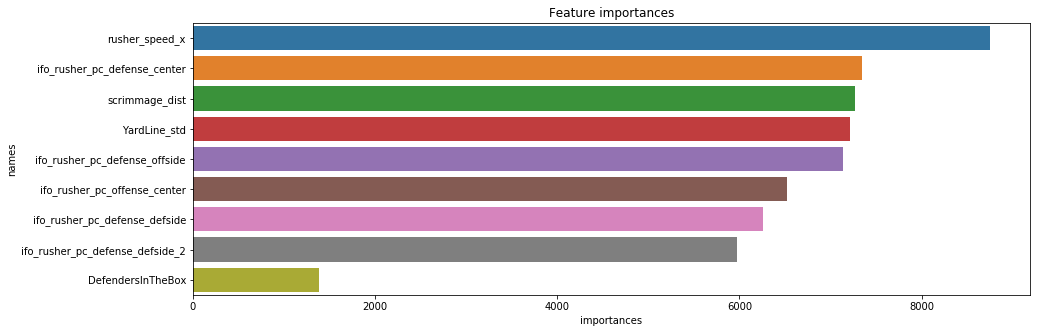

In [24]:
mlt_classifier.plot_importances(final_features, v_size=5)

Checking YardLine_std ...
Checking DefendersInTheBox ...
Checking rusher_speed_x ...
Checking ifo_rusher_pc_offense_center ...
Checking ifo_rusher_pc_defense_center ...
Checking ifo_rusher_pc_defense_defside ...
Checking ifo_rusher_pc_defense_defside_2 ...
Checking ifo_rusher_pc_defense_offside ...
Checking scrimmage_dist ...
CPU times: user 8min 36s, sys: 4.1 s, total: 8min 40s
Wall time: 2min 22s


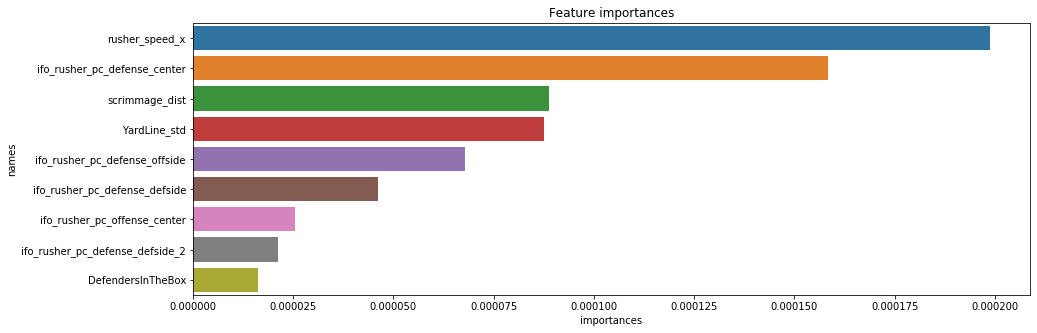

In [38]:
%%time
plot_custom_importances(mlt_classifier, df_play, final_features, scores=scores,
                        v_size=5, cv_type='tss', predict_type='cdf')

## Save evaluation result

In [39]:
solution_scores['v5'] = scores
with open('../data/solution_score.pkl', 'wb') as fout:
    pickle.dump(solution_scores, fout, protocol=pickle.HIGHEST_PROTOCOL)
    
print("v5 score (x100) is better on", 100 * (solution_scores['v4'].mean() - scores.mean()), 
      'then v4 score (x100)')

v5 score (x100) is better on 0.0014583676038428667 then v4 score (x100)


## Fit model

In [168]:
%%time
X_train = df_play[final_features].values
y_train = df_play.Yards.values
mlt_classifier.fit(X_train, y_train)

CPU times: user 2.29 s, sys: 19.7 ms, total: 2.31 s
Wall time: 760 ms


# Predict on test

In [ ]:
from kaggle.competitions import nflrush
env = nflrush.make_env()
columns = ['Yards' + str(i) for i in range(-99, 100)]

for df_test, _ in env.iter_test():
    ## preprocessing
    df_test = preprocess(df_test, is_train=False)
    df_play_test = df_test[df_test.IsBallCarrier].drop(['IsOnOffense', 'IsBallCarrier'], axis=1)
    
    ## FE
    df_test, df_play_test = prepare_features(df_test, df_play_test)
    
    ## predictions
    X_test = df_play_test[final_features].values
    y_pred = mlt_classifier.predict_proba(X_test)
    env.predict(pd.DataFrame(y_pred, columns=columns))
env.write_submission_file()